In [ ]:
import os, sys

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), os.pardir)))
import numpy as np
import pandas as pd
from ppi_py.datasets import load_dataset
from ppi_py import ppi_ols_ci, classical_ols_ci,ppi_ols_pointestimate, debias_pointestimate
from statsmodels.regression.linear_model import OLS
from scipy.optimize import brentq  
from sklearn.linear_model import Ridge
from tqdm import tqdm
from utils import *

In [ ]:
def _ols(X, Y, return_se=False):
    """Computes the ordinary least squares coefficients.

    Args:
        X (ndarray): Covariates.
        Y (ndarray): Labels.
        return_se (bool, optional): Whether to return the standard errors of the coefficients.

    Returns:
        theta (ndarray): Ordinary least squares estimate of the coefficients.
        se (ndarray): If return_se==True, return the standard errors of the coefficients.
    """
    regression = OLS(Y, exog=X).fit()
    theta = regression.params
    if return_se:
        return theta, regression.HC0_se
    else:
        return theta

In [92]:
X_total, Y_total, Yhat_total, theta, _ = generate_data(n_total=900, p=1000, std=1.0)
param = _ols(X_total, Y_total)
error = (theta - param)**2  
error.mean()

0.05948268436156929

In [75]:
def generate_data(
    n_total: int,
    p: int,
    N_model: int = 2000,
    noise: float = 1.0,
    std: float = 1.0,
    mu: float = 0.0,
    theta: np.ndarray = None,
    random_state: int = None
):
    rng = np.random.RandomState(random_state)

    # 1) Generate theta if not provided
    if theta is None:
        theta = rng.uniform(low=-1.0, high=1.0, size=p) # * 100
        # theta = theta / np.linalg.norm(theta)
    
    # 2) Generate total data
    X_total = rng.normal(size=(n_total, p))
    noise_eval = noise * rng.normal(size=n_total)

    Y_total = X_total @ theta + noise_eval

    # 3) Generate predictions
    # X_model = rng.normal(size=(N_model, p))
    # noise_model = std * rng.normal(size=N_model)
    # Y_model = X_model @ theta + noise_model

    # model = OLS(Y_model, X_model).fit()
    # Y_hat = model.predict(X_total)

    # Y_hat = X_total @ theta + std * rng.normal(size=n_total)  # change a way to generate Y_hat

    Y_hat = Y_total + std * rng.normal(size=n_total) - mu  # enforce Yhat to be close to Y_total

    return X_total, Y_total, Y_hat, theta, X_total @ theta

In [4]:
def test(ns, ps, num_trials=10, alpha=0.05, N_total=5000, noise = 1.0, mu=0, std=1.0, lam=None, output_csv="experiment_results.csv"):
    results = []
    for p in ps:
        print(f"Running experiments for p={p}...")
        _X_total, _Y_total, Yhat_total, theta, _ = generate_data(N_total, p, mu=mu, std=std, N_model=2000, noise=noise)
        for n in ns:
            print(f"Running experiments for n={n}...")
            for trial in range(num_trials):
                idx = np.random.permutation(N_total)
                X_labeled, X_unlabeled = _X_total[idx[:n]], _X_total[idx[n:]]
                Y_labeled, Y_unlabeled = _Y_total[idx[:n]], _Y_total[idx[n:]]
                Yhat_labeled, Yhat_unlabeled = Yhat_total[idx[:n]], Yhat_total[idx[n:]]

                # PPI
                try:
                    ppi_point,la = ppi_ols_pointestimate(X_labeled, Y_labeled, Yhat_labeled, X_unlabeled, Yhat_unlabeled, lam=lam)
                    ppi_error = (ppi_point - theta) ** 2
                    results.append({
                        "method": "PPI", "p": p, "n": n, "trial": trial, "std": 1.0, "lambda": la,
                        "theta": theta.mean(),
                        "error": ppi_error.mean(), "error_max": ppi_error.max(), "error_min": ppi_error.min()
                    })
                except Exception as e:
                    print(f"[PPI ERROR] p={p}, trial={trial}: {e}")
                    break

                # Classical
                try:
                    classical_ci = classical_ols_ci(X_labeled, Y_labeled, alpha=alpha)
                    classical_mid = 0.5 * (classical_ci[0] + classical_ci[1])
                    classical_error = (classical_mid - theta) ** 2
                    results.append({
                        "method": "Classical", "p": p, "n": n, "trial": trial, "std": 1.0,
                        "theta": theta.mean(),
                        "error": classical_error.mean(), "error_max": classical_error.max(), "error_min": classical_error.min()
                    })
                except Exception as e:
                    print(f"[Classical ERROR] p={p}, trial={trial}: {e}")
                    break

    df = pd.DataFrame(results)
    df.to_csv(output_csv, index=False)
    print(f"Results saved to {output_csv}")
    return df

In [6]:
import matplotlib.pyplot as plt

def make_plot(cat = "p", type = "error", file = "experiment_results_lam1.csv", note = "Fix n=1000"):
    df = pd.read_csv(file)
    df_avg = df.groupby(["method",cat])[type].mean().reset_index()

    plt.figure(figsize=(10, 6))
    for method in df_avg["method"].unique():
        subset = df_avg[df_avg["method"] == method]
        plt.plot(subset[cat], subset[type], marker='o', label=method)

    plt.title(type + " vs. "+ cat +" ({})".format(note))
    plt.xlabel(cat)
    plt.ylabel(type)
    plt.yscale("log")
    plt.xscale("log")  
    plt.grid(True)
    plt.legend(title="Method")
    plt.tight_layout()
    plt.show()

def make_scatter(p, n, file, type="error"):
    df = pd.read_csv(file)

    sns.set(style="whitegrid", font_scale=1.2)
    plt.figure(figsize=(10, 6))

    sns.scatterplot(data=df, x="trial", y=type, hue="method", style="method")

    plt.yscale("log")

    plt.title("Trial-wise" + type +"(p={}, n={})".format(p, n))
    plt.xlabel("Trial")
    plt.ylabel(type)
    plt.grid(True)
    plt.legend(title="Method")
    plt.tight_layout()
    plt.show()

# Fix n change p

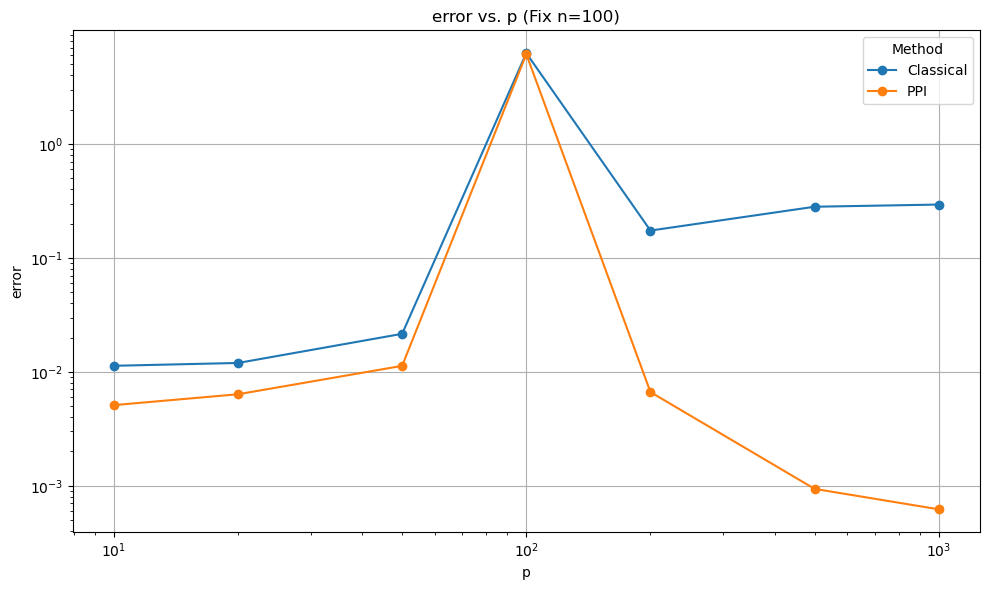

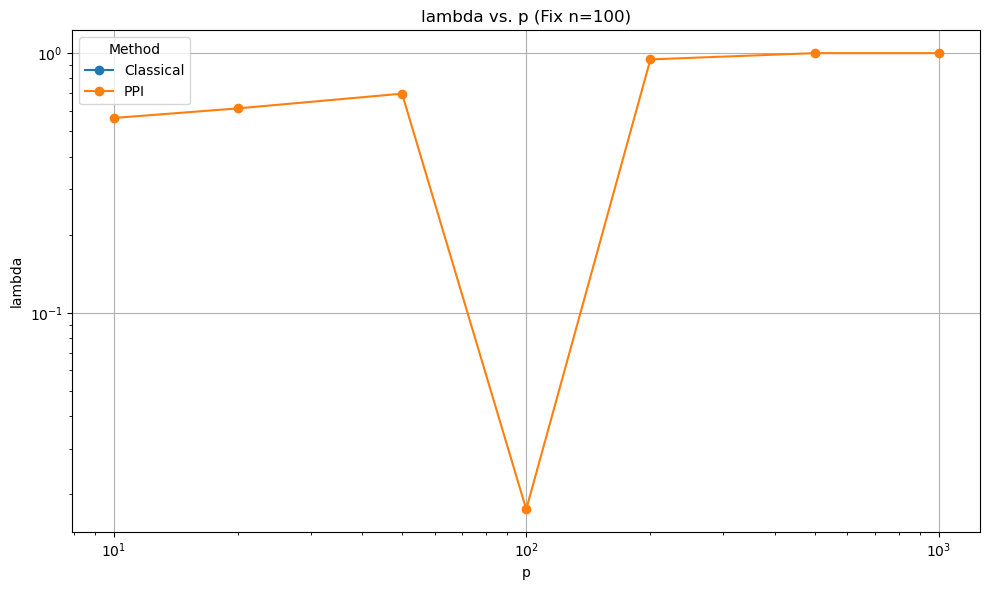

In [8]:
#file_name = "n100.csv"
#test(ns=[100], ps=[10, 20, 50, 100, 200, 500, 1000], output_csv="n100.csv")
#test(ns=[100], ps=[10, 20, 50, 100, 200, 500, 1000], lam=1, output_csv="n100_lamb1.csv")
# test(ns=[100], ps=[10, 20, 50, 100, 200, 500, 1000], output_csv="n100_yhatnear.csv")
#make_plot(cat = "p", type= "lambda", file = "n100_nlarge.csv", note = "Fix n=100")

make_plot(cat = "p", file = "n100_yhatnear.csv", note = "Fix n=100")
make_plot(cat = "p", type= "lambda", file = "n100_yhatnear.csv", note = "Fix n=100")

#make_plot(cat = "p", type= "lambda", file = "n100.csv", note = "Fix n=100")
#make_plot(cat = "p", file = "n100.csv", note = "Fix n=100")
#make_plot(cat = "p", file = "n100_lamb1.csv", note = "Fix n=100")

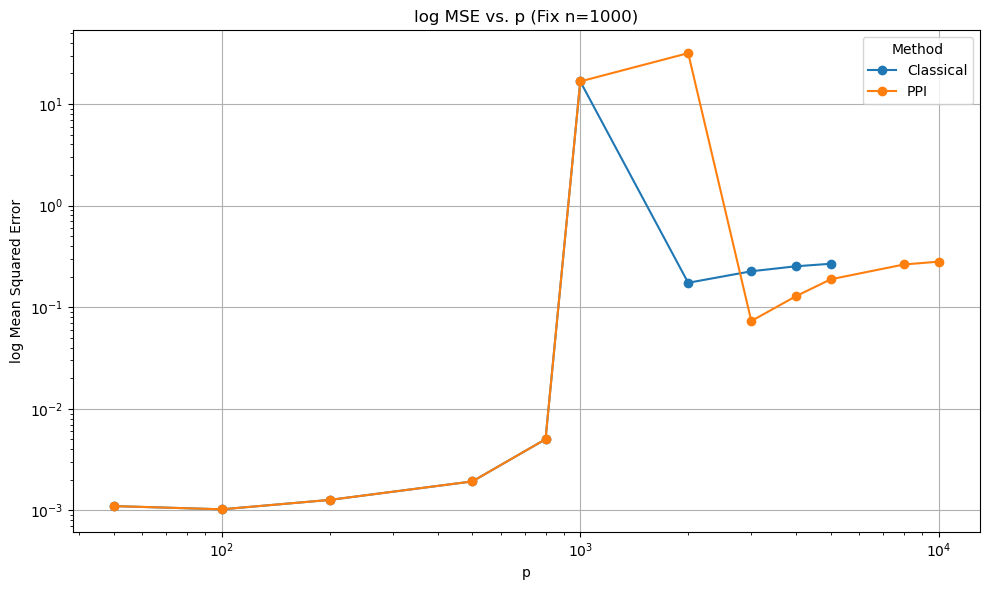

In [ ]:
file_name = "experiment_results5_lam1.csv"
# test(ns=[1000], ps = [50, 100, 200, 500, 800, 1000, 2000, 3000, 4000, 5000, 8000, 10000], lam=1, output_csv=file_name)
make_plot(type = "p", file = file_name, note = "Fix n=1000")

# Fix p change n

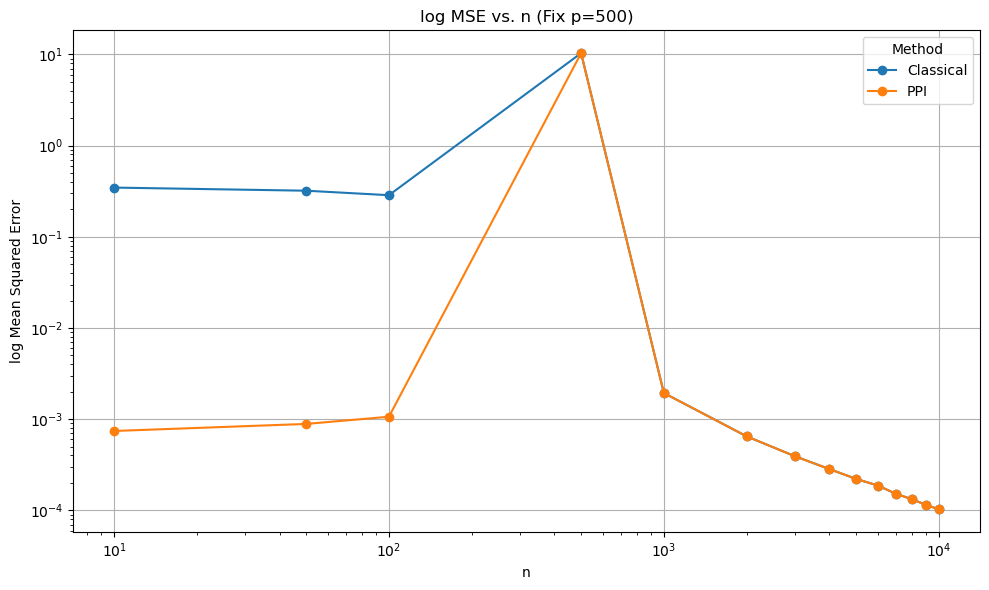

In [ ]:
file_name = "experiment_results6_lam1.csv"
# test(ns=[10, 50, 100, 500, 1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000], ps = [500], lam=1, output_csv=file_name)
make_plot(type = "n", file = file_name, note = "Fix p=500")

# N trials

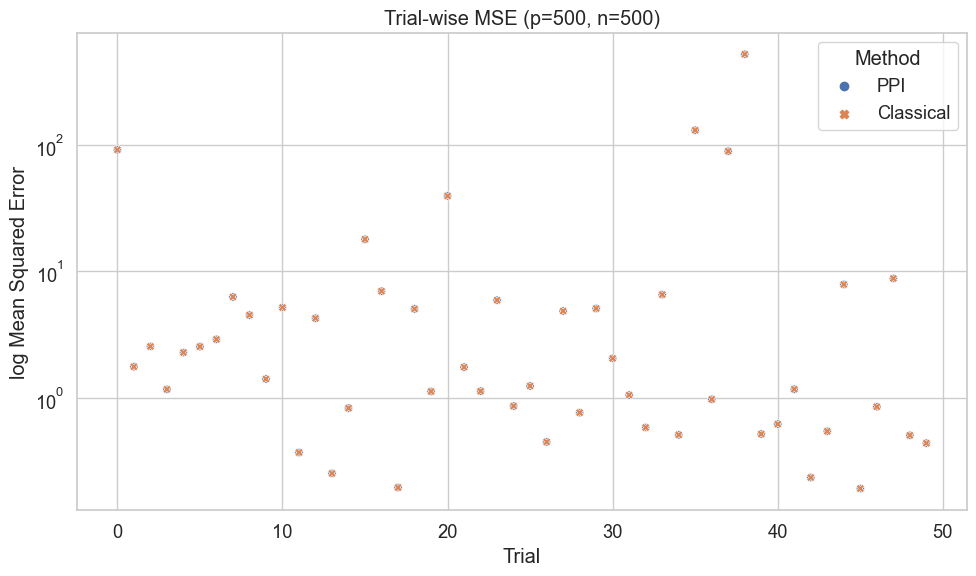

In [24]:
file_name = "experiment_results8_lam1_npsame.csv"
# test(ns=[500], ps = [500], num_trials= 50, lam=1, output_csv=file_name)
make_scatter(p=500, n=500, file=file_name)


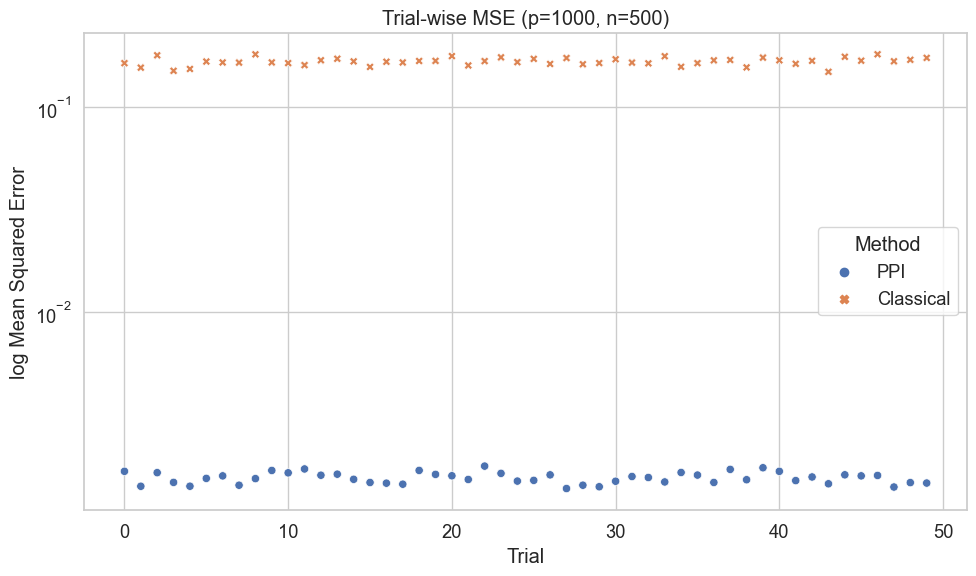

In [25]:
file_name = "experiment_results8_lam1_phigh.csv"
# test(ns=[500], ps = [1000], num_trials= 50, lam=1, output_csv=file_name)
make_scatter(p=1000, n=500, file=file_name)

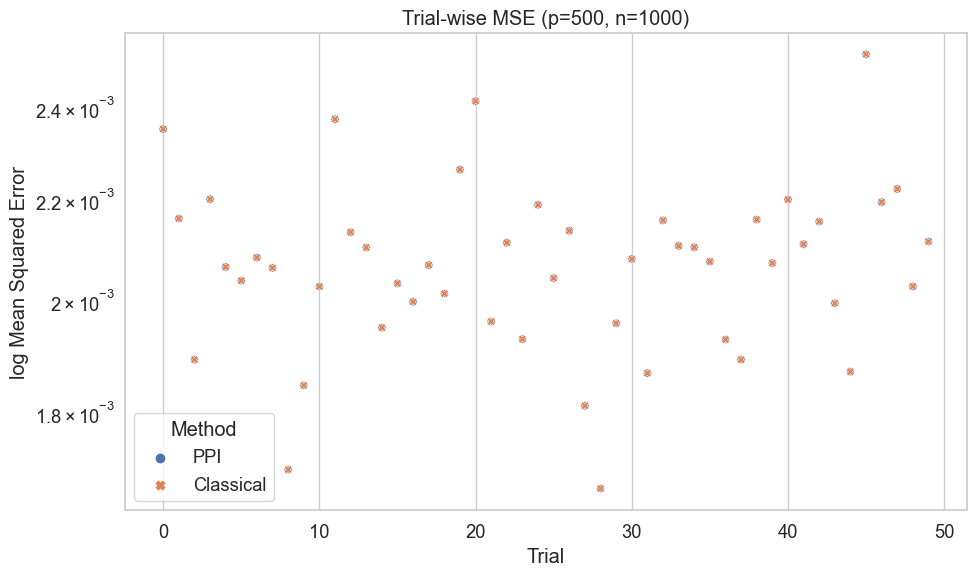

In [26]:
file_name = "experiment_results8_lam1.csv"
# test(ns=[1000], ps = [500], num_trials= 50, lam=1, output_csv=file_name)
make_scatter(p=500, n=1000, file=file_name)

# Test Yhat

In [7]:
for mu in [0, 1, 2, 5]:
    for std in [0.01, 0.1, 1.0, 2.0, 5.0]:
        print(f"Running test with mu={mu}, std={std}")
        test(ns=[10,100,1000,5000], ps=[2,10,50,100,200], num_trials=30, alpha=0.05, N_total=10000, mu=mu, std=std, lam=None, output_csv="Yhat_mu{}_std{}_all2.csv".format(mu,std))

Running test with mu=0, std=0.01
Running experiments for p=2...
Running experiments for n=10...
Running experiments for n=100...
Running experiments for n=1000...
Running experiments for n=5000...
Running experiments for p=10...
Running experiments for n=10...
Running experiments for n=100...
Running experiments for n=1000...
Running experiments for n=5000...
Running experiments for p=50...
Running experiments for n=10...
Running experiments for n=100...
Running experiments for n=1000...
Running experiments for n=5000...
Running experiments for p=100...
Running experiments for n=10...
Running experiments for n=100...
Running experiments for n=1000...
Running experiments for n=5000...
Running experiments for p=200...
Running experiments for n=10...
Running experiments for n=100...
Running experiments for n=1000...
Running experiments for n=5000...
Results saved to Yhat_mu0_std0.01_all2.csv
Running test with mu=0, std=0.1
Running experiments for p=2...
Running experiments for n=10...
Run

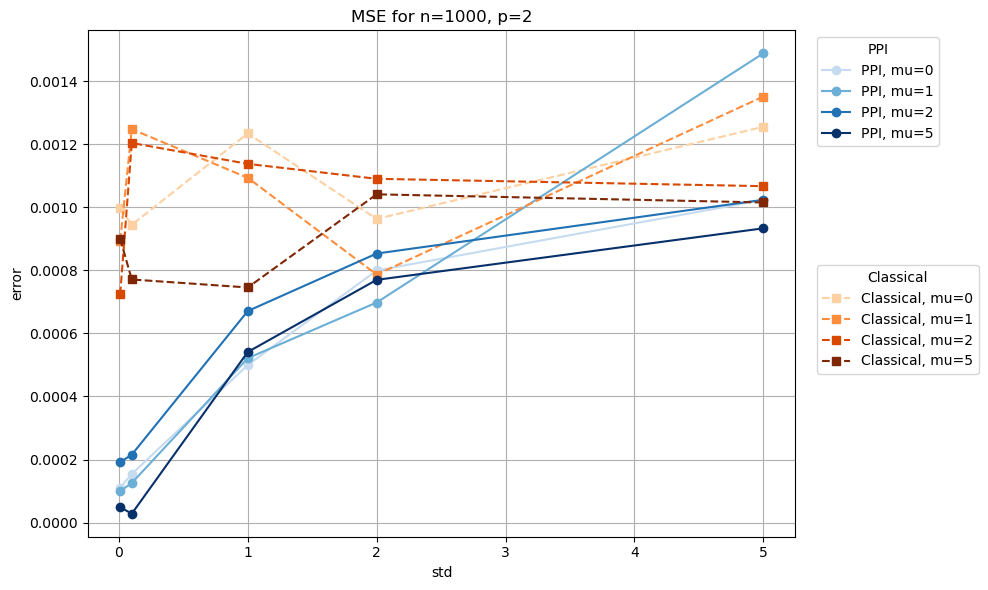

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# -------- 参数设置 --------
target_n = 1000
target_p = 2

mus = [0, 1, 2, 5]
stds = [0.01, 0.1, 1.0, 2.0, 5.0]

# 渐变色
ppi_cmap = cm.get_cmap("Blues", len(mus) + 1)
classical_cmap = cm.get_cmap("Oranges", len(mus) + 1)
ppi_colors = {mu: ppi_cmap(i + 1) for i, mu in enumerate(mus)}
classical_colors = {mu: classical_cmap(i + 1) for i, mu in enumerate(mus)}

# -------- 读入数据并筛选 n/p --------
all_data = []

for mu in mus:
    for std in stds:
        file = f"Yhat_mu{mu}_std{std}_all.csv"
        try:
            df = pd.read_csv(file)
            df["mu"] = mu
            df["std"] = std
            df_filtered = df[(df["n"] == target_n) & (df["p"] == target_p)]
            all_data.append(df_filtered)
        except FileNotFoundError:
            print(f"File not found: {file}")
            continue

df_all = pd.concat(all_data, ignore_index=True)

# 计算平均 error
df_avg = df_all.groupby(["mu", "std", "method"])["error"].mean().reset_index()

# -------- 画图 --------
plt.figure(figsize=(10, 6))
legend_handles_ppi = []
legend_handles_classical = []

for mu in mus:
    # PPI
    sub_ppi = df_avg[(df_avg["mu"] == mu) & (df_avg["method"] == "PPI")]
    h1, = plt.plot(sub_ppi["std"], sub_ppi["error"], color=ppi_colors[mu],
                   linestyle="-", marker="o", label=f"PPI, mu={mu}")
    legend_handles_ppi.append(h1)

    # Classical
    sub_classical = df_avg[(df_avg["mu"] == mu) & (df_avg["method"] == "Classical")]
    h2, = plt.plot(sub_classical["std"], sub_classical["error"], color=classical_colors[mu],
                   linestyle="--", marker="s", label=f"Classical, mu={mu}")
    legend_handles_classical.append(h2)

# 双 legend
first_legend = plt.legend(handles=legend_handles_ppi, title="PPI", loc='upper left', bbox_to_anchor=(1.02, 1))
second_legend = plt.legend(handles=legend_handles_classical, title="Classical", loc='upper left', bbox_to_anchor=(1.02, 0.55))
plt.gca().add_artist(first_legend)

plt.xlabel("std")
plt.ylabel("error")
plt.title(f"MSE for n={target_n}, p={target_p}")
plt.grid(True)
plt.tight_layout()
plt.show()


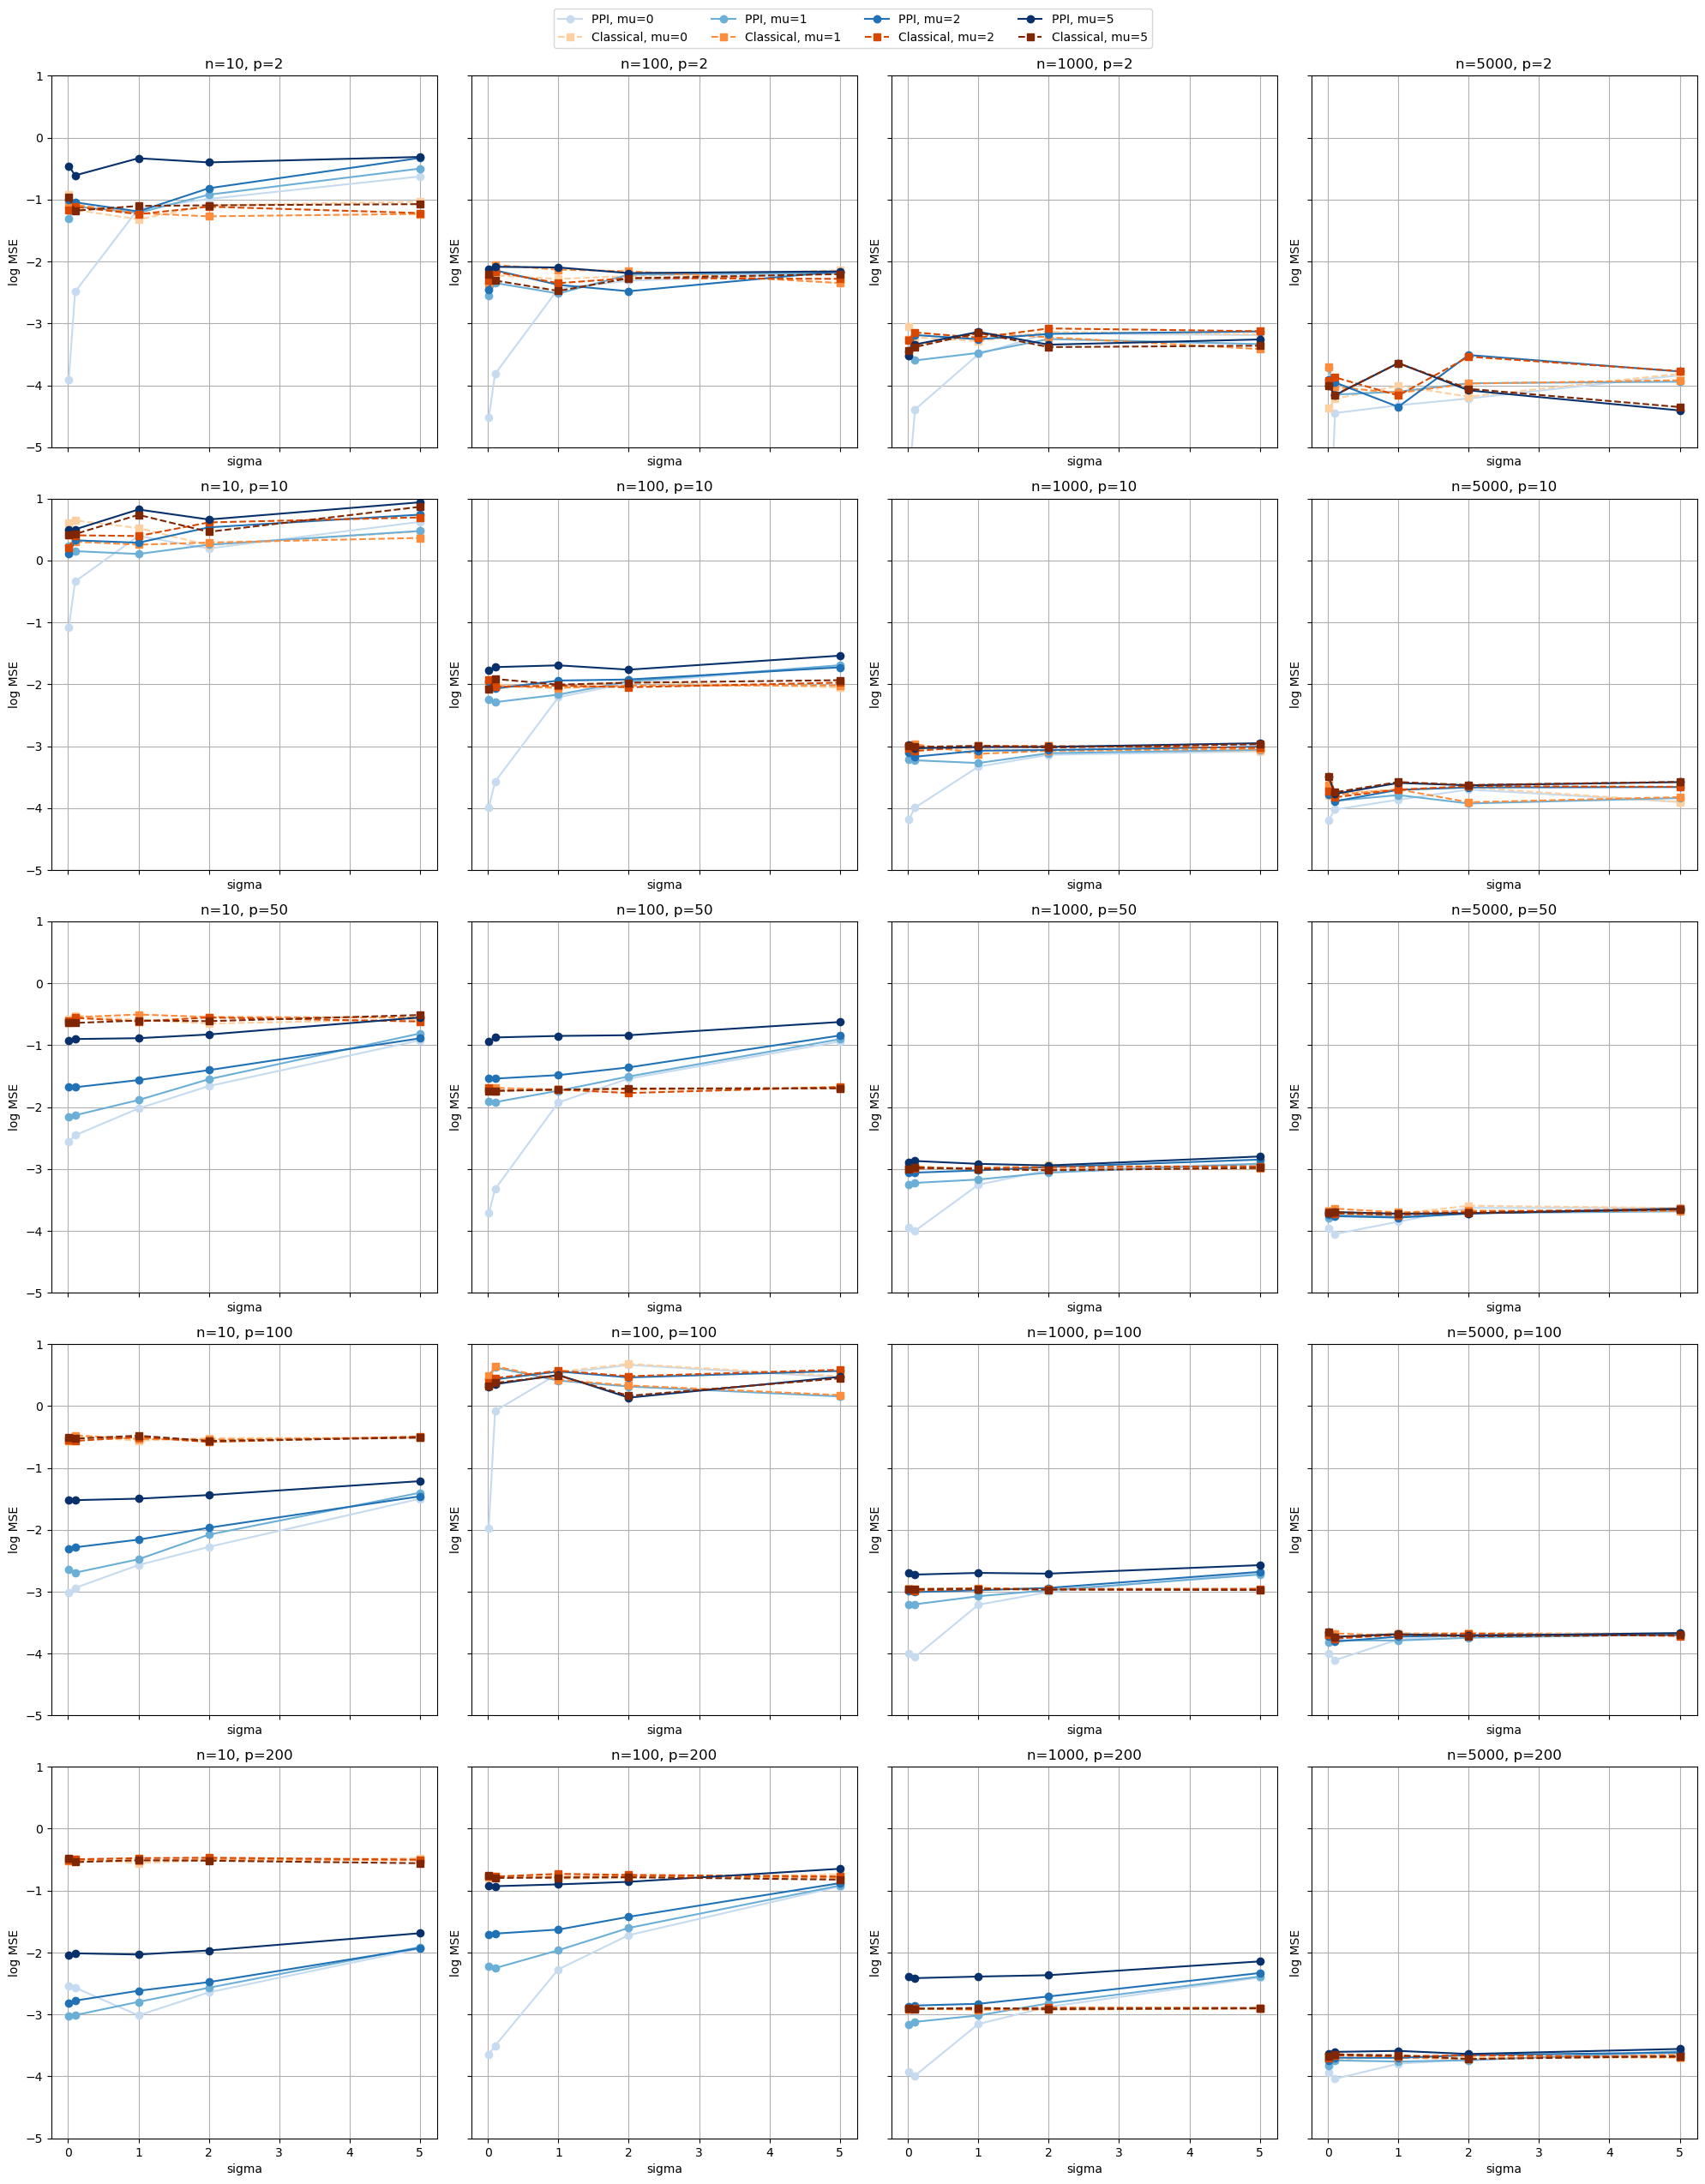

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import os

# 参数设置
mus = [0, 1, 2, 5]
stds = [0.01, 0.1, 1.0, 2.0, 5.0]
ns = [10, 100, 1000, 5000]
ps = [2, 10, 50, 100, 200]

ppi_cmap = cm.get_cmap("Blues", len(mus) + 1)
classical_cmap = cm.get_cmap("Oranges", len(mus) + 1)
ppi_colors = {mu: ppi_cmap(i + 1) for i, mu in enumerate(mus)}
classical_colors = {mu: classical_cmap(i + 1) for i, mu in enumerate(mus)}

# 读取所有数据
all_data = []

for mu in mus:
    for std in stds:
        file = f"Yhat_mu{mu}_std{std}_all2.csv"
        if os.path.exists(file):
            df = pd.read_csv(file)
            df["mu"] = mu
            df["std"] = std
            df["log_error"] = np.log10(df["error"] + 1e-8)  # 避免 log(0)
            all_data.append(df)

df_all = pd.concat(all_data, ignore_index=True)

# 开始画 5x4 个子图
fig, axes = plt.subplots(5, 4, figsize=(20, 25), sharex=True, sharey=True)
fig.subplots_adjust(hspace=0.4, wspace=0.3)

for i, p in enumerate(ps):
    for j, n in enumerate(ns):
        ax = axes[i, j]
        df_sub = df_all[(df_all["n"] == n) & (df_all["p"] == p)]
        df_avg = df_sub.groupby(["mu", "std", "method"])["log_error"].mean().reset_index()

        for mu in mus:
            # PPI
            sub_ppi = df_avg[(df_avg["mu"] == mu) & (df_avg["method"] == "PPI")]
            ax.plot(sub_ppi["std"], sub_ppi["log_error"], color=ppi_colors[mu],
                    linestyle="-", marker="o", label=f"PPI, mu={mu}")

            # Classical
            sub_classical = df_avg[(df_avg["mu"] == mu) & (df_avg["method"] == "Classical")]
            ax.plot(sub_classical["std"], sub_classical["log_error"], color=classical_colors[mu],
                    linestyle="--", marker="s", label=f"Classical, mu={mu}")

        ax.set_title(f"n={n}, p={p}")
        ax.set_xlabel("sigma")
        ax.set_ylabel("log MSE")
        ax.grid(True)

# 图例放外面
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=4, bbox_to_anchor=(0.5, 1.02))

axes[0, 0].set_ylim(-5, 1)


plt.tight_layout()
plt.show()


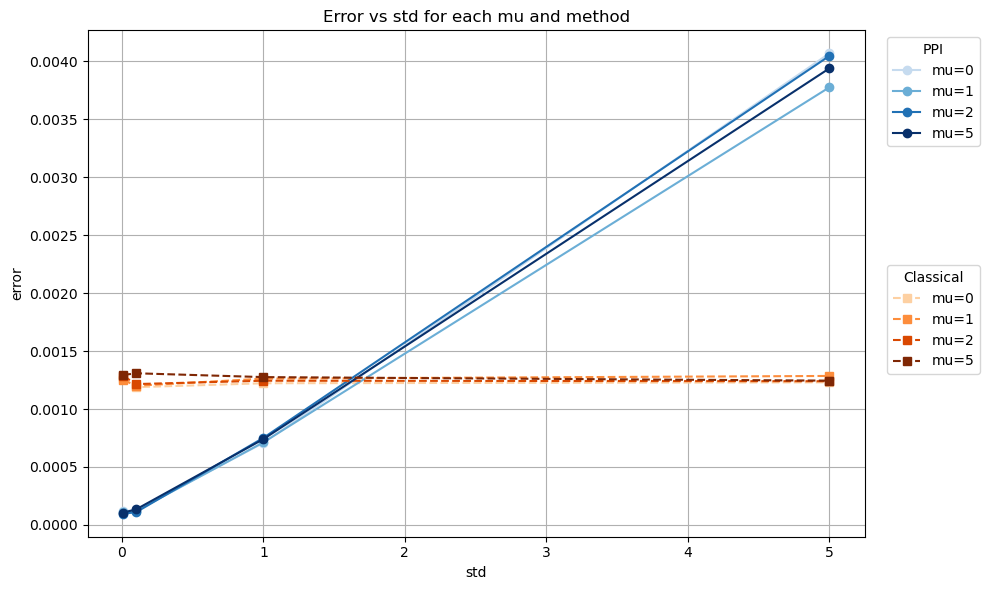

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.cm as cm

mus = [0, 1, 2, 5]
stds = [0.01, 0.1, 1.0, 2.0, 5.0]

ppi_cmap = cm.get_cmap("Blues", len(mus) + 1)
classical_cmap = cm.get_cmap("Oranges", len(mus) + 1)

ppi_colors = {mu: ppi_cmap(i + 1) for i, mu in enumerate(mus)}
classical_colors = {mu: classical_cmap(i + 1) for i, mu in enumerate(mus)}

plt.figure(figsize=(10, 6))
all_data = []

for mu in mus:
    for std in stds:
        file = f"Yhat_mu{mu}_std{std}_p2.csv"
        df = pd.read_csv(file)
        df["mu"] = mu
        df["std"] = std
        all_data.append(df[df["p"] == 200])  # Filter for p=2

df_all = pd.concat(all_data)
df_avg = df_all.groupby(["mu", "std", "method"])["error"].mean().reset_index()

# Plotting
legend_handles_ppi = []
legend_handles_classical = []

for mu in mus:
    # PPI
    sub_ppi = df_avg[(df_avg["mu"] == mu) & (df_avg["method"] == "PPI")]
    h1, = plt.plot(sub_ppi["std"], sub_ppi["error"], color=ppi_colors[mu],
                   linestyle="-", marker="o", label=f"mu={mu}")
    legend_handles_ppi.append(h1)

    # Classical
    sub_classical = df_avg[(df_avg["mu"] == mu) & (df_avg["method"] == "Classical")]
    h2, = plt.plot(sub_classical["std"], sub_classical["error"], color=classical_colors[mu],
                   linestyle="--", marker="s", label=f"mu={mu}")
    legend_handles_classical.append(h2)


first_legend = plt.legend(handles=legend_handles_ppi, title="PPI", loc='upper left', bbox_to_anchor=(1.02, 1))
second_legend = plt.legend(handles=legend_handles_classical, title="Classical", loc='upper left', bbox_to_anchor=(1.02, 0.55))
plt.gca().add_artist(first_legend)  

plt.xlabel("std")
plt.ylabel("error")
plt.title("MSE for n=1000, p=2")
plt.grid(True)
plt.tight_layout()
plt.show()

## Sigma as the function

fix N=1000, n=100, p=[10,20,50,100,200,500,1000,2000], sigma =[0.01, 0.1, 1.0, 2.0, 5.0]

In [5]:
for std in [0.01, 0.1, 1.0, 2.0, 5.0]:
    print(f"Running test with std={std}")
    test(ns=[100], ps=[10,50,100,500,1000,2000], num_trials=20, alpha=0.05, N_total=1000, std=std, lam=None, output_csv="sigma_{}.csv".format(std))

Running test with std=0.01
Running experiments for p=10...
Running experiments for n=100...
Running experiments for p=50...
Running experiments for n=100...
Running experiments for p=100...
Running experiments for n=100...
Running experiments for p=500...
Running experiments for n=100...
Running experiments for p=1000...
Running experiments for n=100...
Running experiments for p=2000...
Running experiments for n=100...
Results saved to sigma_0.01.csv
Running test with std=0.1
Running experiments for p=10...
Running experiments for n=100...
Running experiments for p=50...
Running experiments for n=100...
Running experiments for p=100...
Running experiments for n=100...
Running experiments for p=500...
Running experiments for n=100...
Running experiments for p=1000...
Running experiments for n=100...
Running experiments for p=2000...
Running experiments for n=100...
Results saved to sigma_0.1.csv
Running test with std=1.0
Running experiments for p=10...
Running experiments for n=100...
R

In [ ]:
for std in [0.01, 0.1, 1.0, 2.0, 5.0]:
    print(f"Running test with std={std}")
    test(ns=[100], ps=[10,50,100,500,1000,5000,10000,20000], num_trials=20, alpha=0.05, N_total=10000, std=std, lam=None, output_csv="sigma2_{}.csv".format(std))

Running test with std=0.01
Running experiments for p=10...
Running experiments for n=100...
Running experiments for p=50...
Running experiments for n=100...
Running experiments for p=100...
Running experiments for n=100...
Running experiments for p=500...
Running experiments for n=100...
Running experiments for p=1000...
Running experiments for n=100...
Running experiments for p=5000...
Running experiments for n=100...
Running experiments for p=10000...
Running experiments for n=100...


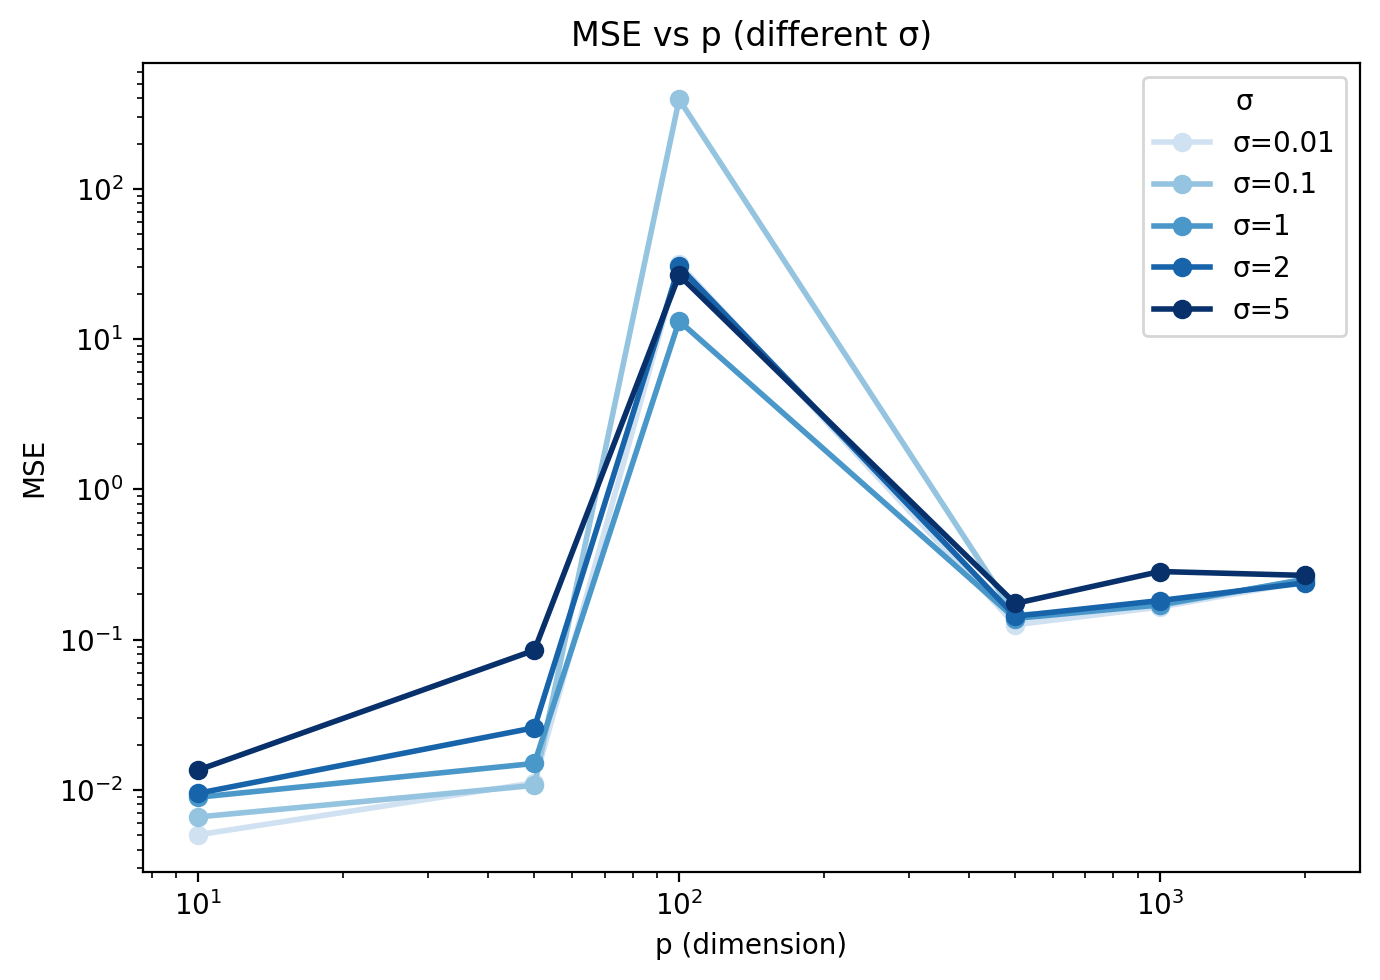

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
import glob, os, re

# === 读取所有 sigma_*.csv 文件 ===
files = sorted(glob.glob("sigma_*.csv"))
dfs = []
for f in files:
    m = re.search(r"sigma_([0-9.]+)\.csv", os.path.basename(f))
    if m:
        sigma = float(m.group(1))
        df = pd.read_csv(f)
        df["sigma"] = sigma
        dfs.append(df)

if not dfs:
    raise FileNotFoundError("没有找到 sigma_*.csv 文件")

data = pd.concat(dfs, ignore_index=True)

# === 按 (sigma, p) 聚合取均值 ===
summary = data.groupby(["sigma", "p"], as_index=False)["error"].mean()

# === 给每个 sigma 分配渐变色 ===
sigmas = np.sort(summary["sigma"].unique())
ppi_cmap = cm.get_cmap("Blues", len(sigmas) + 1)   # 生成 N+1 个颜色
ppi_colors = {s: ppi_cmap(i + 1) for i, s in enumerate(sigmas)}  # 跳过最浅色

# === 绘图 ===
plt.figure(figsize=(7,5), dpi=200)

for sigma, g in summary.groupby("sigma"):
    g = g.sort_values("p")
    plt.plot(
        g["p"], g["error"],
        marker="o", lw=2,
        color=ppi_colors[sigma],
        label=f"σ={sigma:g}"
    )

plt.xscale("log")   # p 范围大
plt.yscale("log")   # MSE 范围大
plt.xlabel("p (dimension)")
plt.ylabel("MSE")
plt.title("MSE vs p (different σ)")
plt.legend(title="σ")
plt.tight_layout()
plt.show()


fix N=1000, p=100, n=[10,20,50,100,200,500,1000,2000], sigma =[0.01, 0.1, 1.0, 2.0, 5.0]

## The naive Debiasing method

Yhat = Y + bias

(1) bias = f(x)

(2) Y = Yhat - f(x)

n=100, p=1000, N=300

# Comparision

In [18]:
N_total = 3000 
n = 100
_X_total, _Y_total, Yhat_total, theta, _ = generate_data(n_total=N_total, p=1000)
idx = np.random.permutation(N_total)
X_labeled, X_unlabeled = _X_total[idx[:n]], _X_total[idx[n:]]
Y_labeled, Y_unlabeled = _Y_total[idx[:n]], _Y_total[idx[n:]]
Yhat_labeled, Yhat_unlabeled = Yhat_total[idx[:n]], Yhat_total[idx[n:]]

In [19]:
ppi_point, la = ppi_ols_pointestimate(X_labeled, Y_labeled, Yhat_labeled, X_unlabeled, Yhat_unlabeled)
debias_point = debias_pointestimate(X_labeled, Y_labeled, Yhat_labeled, X_unlabeled, Yhat_unlabeled)

ppi_error = (ppi_point - theta) ** 2
debias_error = (debias_point - theta) ** 2

print(f"PPI estimate mean: {ppi_error.mean()}, Debias estimate mean: {debias_error.mean()}, True theta mean: {theta.mean()}")   

PPI estimate mean: 0.0011525339638982582, Debias estimate mean: 0.0010496797700928868, True theta mean: 0.02271751552881523


In [26]:
def test2(ns, ps, num_trials=10, alpha=0.05, N_total=5000, noise = 1.0, mu=0, std=1.0, lam=None, output_csv="debias_compare.csv"):
    results = []
    for p in ps:
        print(f"Running experiments for p={p}...")
        _X_total, _Y_total, Yhat_total, theta, _ = generate_data(N_total, p, mu=mu, std=std, N_model=2000, noise=noise)
        for n in ns:
            print(f"Running experiments for n={n}...")
            for trial in range(num_trials):
                idx = np.random.permutation(N_total)
                X_labeled, X_unlabeled = _X_total[idx[:n]], _X_total[idx[n:]]
                Y_labeled, Y_unlabeled = _Y_total[idx[:n]], _Y_total[idx[n:]]
                Yhat_labeled, Yhat_unlabeled = Yhat_total[idx[:n]], Yhat_total[idx[n:]]

                # PPI
                try:
                    ppi_point,la = ppi_ols_pointestimate(X_labeled, Y_labeled, Yhat_labeled, X_unlabeled, Yhat_unlabeled, lam=lam)
                    ppi_error = (ppi_point - theta) ** 2
                    results.append({
                        "method": "PPI", "p": p, "n": n, "trial": trial, "std": 1.0, "lambda": la,
                        "theta": theta.mean(),
                        "error": ppi_error.mean(), "error_max": ppi_error.max(), "error_min": ppi_error.min()
                    })
                except Exception as e:
                    print(f"[PPI ERROR] p={p}, trial={trial}: {e}")
                    break

                # Debias
                try:
                    debias_point = debias_pointestimate(X_labeled, Y_labeled, Yhat_labeled, X_unlabeled, Yhat_unlabeled)
                    debias_error = (debias_point - theta) ** 2
                    results.append({
                        "method": "Debias", "p": p, "n": n, "trial": trial, "std": 1.0,
                        "theta": theta.mean(),
                        "error": debias_error.mean(), "error_max": debias_error.max(), "error_min": debias_error.min()
                    })
                except Exception as e:
                    print(f"[Debias ERROR] p={p}, trial={trial}: {e}")
                    break

                # Classical
                try:
                    classical_ci = classical_ols_ci(X_labeled, Y_labeled, alpha=alpha)
                    classical_mid = 0.5 * (classical_ci[0] + classical_ci[1])
                    classical_error = (classical_mid - theta) ** 2
                    results.append({
                        "method": "Classical", "p": p, "n": n, "trial": trial, "std": 1.0,
                        "theta": theta.mean(),
                        "error": classical_error.mean(), "error_max": classical_error.max(), "error_min": classical_error.min()
                    })
                except Exception as e:
                    print(f"[Classical ERROR] p={p}, trial={trial}: {e}")
                    break

        # imputed
        try:
            imputed_ci = classical_ols_ci(_X_total, Yhat_total)
            imputed_point = 0.5 * (imputed_ci[0] + imputed_ci[1])
            imputed_error = (imputed_point - theta) ** 2
            results.append({
                "method": "Imputed", "p": p, "n": n, "trial": trial, "std": 1.0,
                "theta": theta.mean(),
                "error": imputed_error.mean(), "error_max": imputed_error.max(), "error_min": imputed_error.min()
            })
        except Exception as e:
            print(f"[Imputed ERROR] p={p}, trial={trial}: {e}")
            break

    df = pd.DataFrame(results)
    df.to_csv(output_csv, index=False)
    print(f"Results saved to {output_csv}")
    return df

In [27]:
for sigma in [0.01, 0.1, 1.0, 5.0]:
    print(f"Running test with sigma={sigma}")
    test2(ns=[100], ps=[2, 10, 100, 200, 1000], num_trials=30, alpha=0.05, N_total=300, std=sigma, lam=None, output_csv="debias_N300_compare_{}.csv".format(sigma))
    test2(ns=[100, 600], ps=[2, 10, 100, 200, 1000], num_trials=30, alpha=0.05, N_total=3000, std=sigma, lam=None, output_csv="debias_N3000_compare_{}.csv".format(sigma))

Running test with sigma=0.01
Running experiments for p=2...
Running experiments for n=100...
Running experiments for p=10...
Running experiments for n=100...
Running experiments for p=100...
Running experiments for n=100...
Running experiments for p=200...
Running experiments for n=100...
Running experiments for p=1000...
Running experiments for n=100...
Results saved to debias_N300_compare_0.01.csv
Running experiments for p=2...
Running experiments for n=100...
Running experiments for n=600...
Running experiments for p=10...
Running experiments for n=100...
Running experiments for n=600...
Running experiments for p=100...
Running experiments for n=100...
Running experiments for n=600...
Running experiments for p=200...
Running experiments for n=100...
Running experiments for n=600...
Running experiments for p=1000...
Running experiments for n=100...
Running experiments for n=600...
Results saved to debias_N3000_compare_0.01.csv
Running test with sigma=0.1
Running experiments for p=2..

### Plots

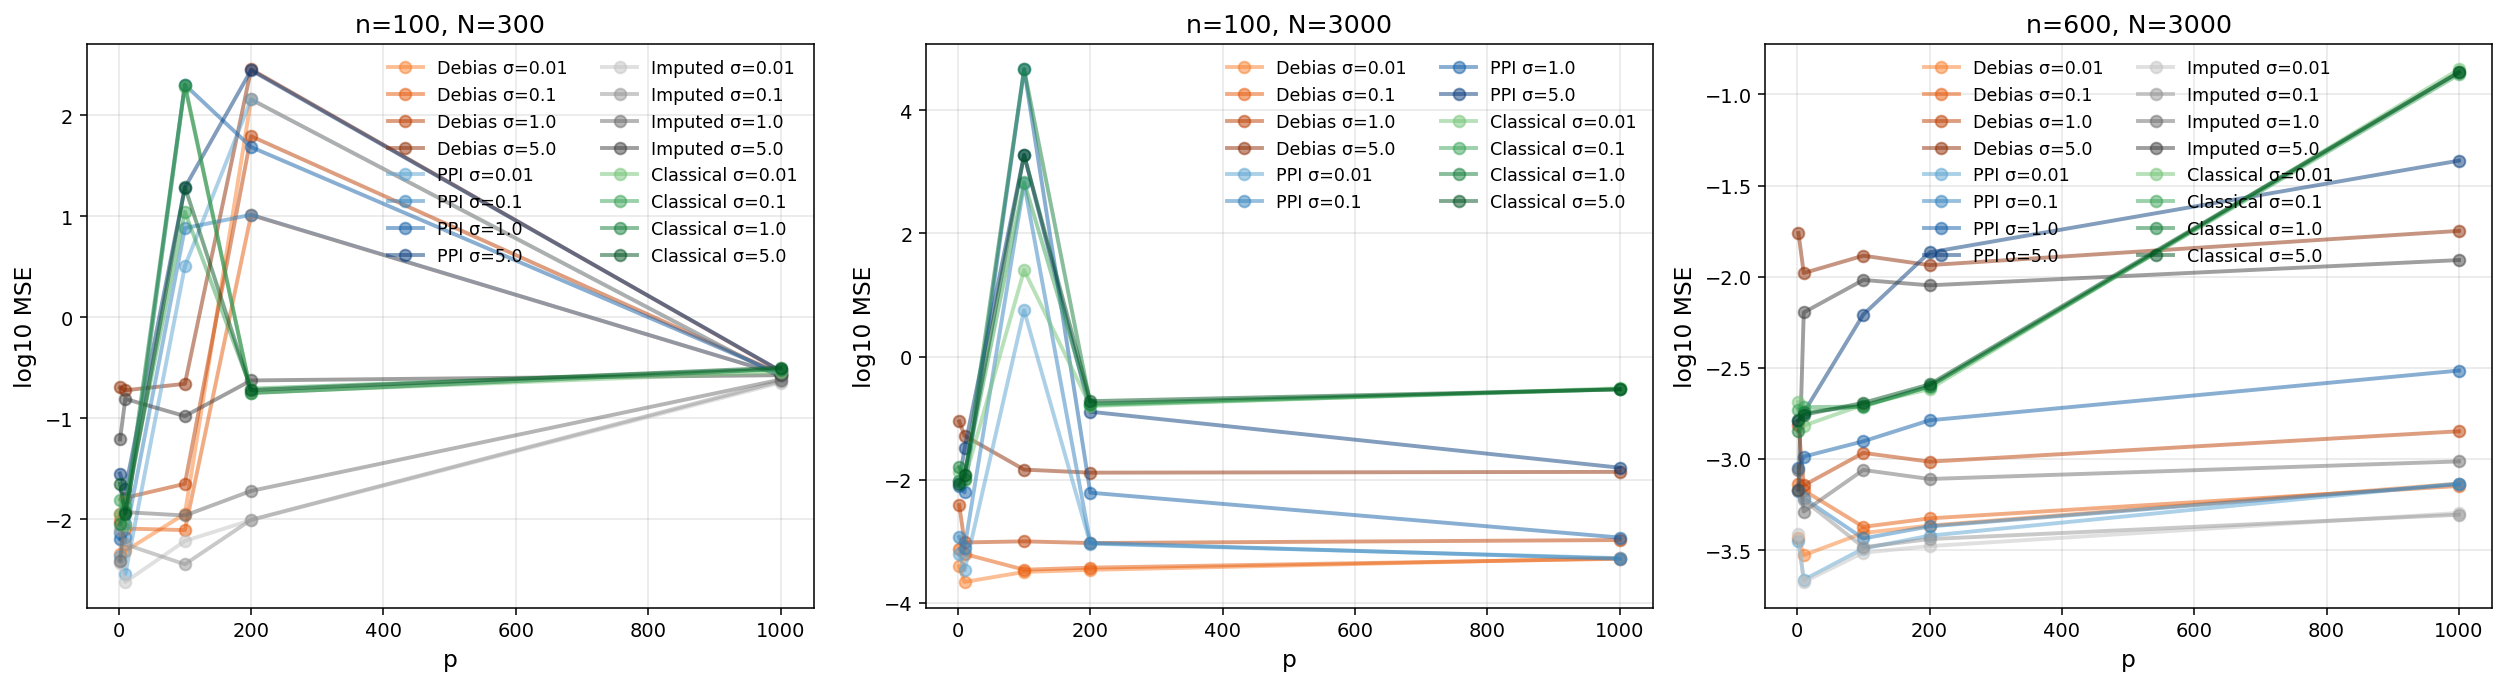

In [116]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm

# ==== 配置 ====
sigma_str_list = ["0.01", "0.1", "1.0", "5.0"]
sigma_values = [float(s) for s in sigma_str_list]

files_by_N = {
    300:  "debias_N300_compare_{s}.csv",
    3000: "debias_N3000_compare_{s}.csv",
}

ALPHA = 0.50  # 统一透明度

def make_palette(cmap_name, start, end, n):
    cmap = cm.get_cmap(cmap_name)
    return [cmap(x) for x in np.linspace(start, end, n)]

# 四类方法的渐变色：避免太浅/太深的区间，增强可读性
PALETTES = {
    "Debias":   make_palette("Oranges", 0.55, 0.95, len(sigma_values)),
    "PPI":      make_palette("Blues",   0.55, 0.95, len(sigma_values)),
    "Imputed":  make_palette("Greys",   0.35, 0.80, len(sigma_values)),
    "Classical":make_palette("Greens",  0.50, 0.95, len(sigma_values)),
}

def load_all():
    frames = []
    for N_total, patt in files_by_N.items():
        for s_str, s_val in zip(sigma_str_list, sigma_values):
            path = patt.format(s=s_str)
            if not os.path.exists(path):
                print(f"[WARN] 找不到文件: {path}，跳过该 σ={s_str}, N_total={N_total}")
                continue
            df = pd.read_csv(path)
            df["sigma"] = s_val
            df["sigma_str"] = s_str
            df["N_total_file"] = N_total
            frames.append(df)
    if not frames:
        raise FileNotFoundError("没有读到任何 CSV，请检查文件名与目录。")
    return pd.concat(frames, ignore_index=True)

df = load_all()

# trial 维度聚合 => 平均 MSE，再取 log10
grp = (df.groupby(["N_total_file", "n", "p", "method", "sigma", "sigma_str"], as_index=False)
         .agg(mean_mse=("error", "mean")))
grp["log10_mse"] = np.log10(np.clip(grp["mean_mse"], 1e-300, None))

def plot_panel(ax, data, title):
    for method in ["Debias", "PPI", "Imputed", "Classical"]:
        sub = data[data["method"] == method]
        if sub.empty:
            continue
        palette = PALETTES[method]
        for i, (s_val, s_str) in enumerate(zip(sigma_values, sigma_str_list)):
            d = sub[sub["sigma"] == s_val].sort_values("p")
            if d.empty:
                continue
            ax.plot(
                d["p"], d["log10_mse"],
                marker="o", lw=2,
                color=palette[i],
                alpha=ALPHA,
                label=f"{method} σ={s_str}",
            )
    ax.set_xlabel("p", fontsize=12)
    ax.set_ylabel("log10 MSE", fontsize=12)
    ax.set_title(title, fontsize=13)
    ax.grid(True, alpha=0.3)
    ax.legend(ncol=2, fontsize=9, frameon=False)

# 三张图
fig, axes = plt.subplots(1, 3, figsize=(18, 5), dpi=140)

panel1 = grp[(grp["n"] == 100) & (grp["N_total_file"] == 300)]
plot_panel(axes[0], panel1, "n=100, N=300")

panel2 = grp[(grp["n"] == 100) & (grp["N_total_file"] == 3000)]
plot_panel(axes[1], panel2, "n=100, N=3000")

panel3 = grp[(grp["n"] == 600) & (grp["N_total_file"] == 3000)]
plot_panel(axes[2], panel3, "n=600, N=3000")

plt.tight_layout()
plt.show()
fig.savefig("../plots/ppi_debias_compare_three_panels_all.png", bbox_inches="tight")


In [39]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm

def plot_ppi_debias_by_sigma(
    n, p, N_total,
    sigma_str_list=("0.01", "0.1", "1.0", "5.0"),
    files_by_N=None,
    alpha=0.80,
    ax=None,
    savepath=None,
    show=True,
):
    
    sigma_str_list = list(sigma_str_list)
    sigma_values = [float(s) for s in sigma_str_list]

    if files_by_N is None:
        files_by_N = {
            300:  "debias_N300_compare_{s}.csv",
            3000: "debias_N3000_compare_{s}.csv",
        }
    # 选取模板或回退模板
    patt = files_by_N.get(N_total, f"debias_N{N_total}_compare_{{s}}.csv")

    # 渐变调色板
    def make_palette(cmap_name, start, end, n_colors):
        cmap = cm.get_cmap(cmap_name)
        return [cmap(x) for x in np.linspace(start, end, n_colors)]

    PALETTES = {
        "Debias":    make_palette("Oranges", 0.55, 0.95, len(sigma_values)),
        "PPI":       make_palette("Blues",   0.55, 0.95, len(sigma_values)),
        "Imputed":   make_palette("Greys",   0.35, 0.80, len(sigma_values)),
        "Classical": make_palette("Greens",  0.50, 0.95, len(sigma_values)),
    }

    # 读取该 N_total 下所有 σ 的文件
    frames = []
    for s_str, s_val in zip(sigma_str_list, sigma_values):
        path = patt.format(s=s_str)
        if not os.path.exists(path):
            print(f"[WARN] 找不到文件: {path}（跳过 σ={s_str}）")
            continue
        df = pd.read_csv(path)
        df["sigma"] = s_val
        df["sigma_str"] = s_str
        frames.append(df)

    if not frames:
        raise FileNotFoundError("没有读到任何 CSV；请检查文件名与目录。")

    data = pd.concat(frames, ignore_index=True)
    sub = data[(data["n"] == n) & (data["p"] == p)].copy()
    if sub.empty:
        raise ValueError(f"筛选后为空：CSV 中没有 n={n}, p={p} 的行（N_total={N_total}）。")

    # trial 平均 -> log10 MSE
    agg = (sub.groupby(["method", "sigma", "sigma_str"], as_index=False)
               .agg(mean_mse=("error", "mean")))
    agg["log10_mse"] = np.log10(np.clip(agg["mean_mse"], 1e-300, None))

    methods = ["Debias", "PPI", "Imputed", "Classical"]

    created_ax = False
    if ax is None:
        fig, ax = plt.subplots(figsize=(6.4, 4.8), dpi=140)
        created_ax = True

    # 画线 + 渐变色散点
    for method in methods:
        m = agg[agg["method"] == method].copy()
        if m.empty:
            continue
        # 按 σ 顺序
        m["sigma"] = pd.Categorical(m["sigma"], categories=sigma_values, ordered=True)
        m.sort_values("sigma", inplace=True)

        palette = PALETTES[method]
        # 连接线用调色板偏深的一支，保证可读性
        line_color = palette[-2] if len(palette) >= 2 else palette[0]
        ax.plot(m["sigma"].astype(float), m["log10_mse"],
                lw=2, color=line_color, alpha=alpha, label=method)
        # 各 σ 的点用渐变色
        for i, row in enumerate(m.itertuples(index=False)):
            ax.scatter(float(row.sigma), row.log10_mse,
                       s=60, color=palette[i], alpha=alpha, edgecolor="none")

    # 坐标轴样式
    ax.set_xscale("log")
    ax.set_xticks(sigma_values)
    ax.set_xticklabels(sigma_str_list)  # 显示与文件名一致的 0.01/0.1/1.0/5.0
    ax.set_xlabel("σ", fontsize=12)
    ax.set_ylabel("log10 MSE", fontsize=12)
    ax.set_title(f"n={n}, N={N_total}, p={p}", fontsize=13)
    ax.grid(True, which="both", alpha=0.3)
    ax.legend(frameon=False, ncol=2, fontsize=9)

    if savepath:
        plt.tight_layout()
        plt.savefig(savepath, bbox_inches="tight")
    if show and created_ax:
        plt.tight_layout()
        plt.show()

    return ax

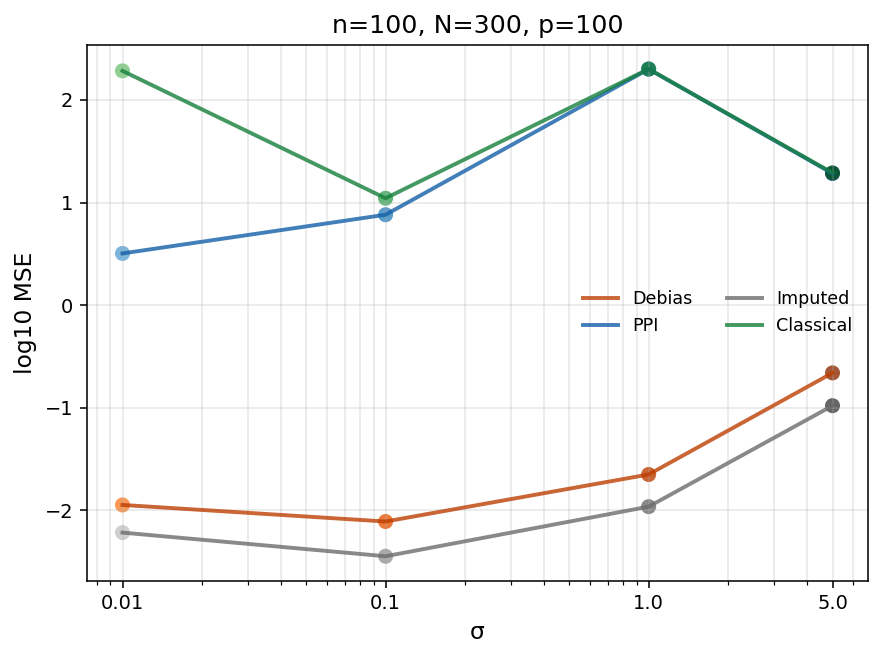

<Axes: title={'center': 'n=100, N=300, p=100'}, xlabel='σ', ylabel='log10 MSE'>

In [ ]:
plot_ppi_debias_by_sigma(n=100, p=100, N_total=300,savepath="../plots/ppi_debias_n100_p10_N300.png")

In [99]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm

# ===================== 基础配置 =====================
SIGMA_STR = ("0.01", "0.1", "1.0", "5.0")  # 严格匹配你的文件命名
SIGMA_VAL = [float(s) for s in SIGMA_STR]
FILES_BY_N = {
    300:  "debias_N300_compare_{s}.csv",
    3000: "debias_N3000_compare_{s}.csv",
}
ALPHA = 0.85  # 统一透明度

def _make_palette(cmap_name, start=0.55, end=0.95, n=4):
    cmap = cm.get_cmap(cmap_name)
    return [cmap(x) for x in np.linspace(start, end, n)]

# 颜色：按 σ 渐变（蓝色）
PALETTE_SIGMA = _make_palette("Blues", 0.55, 0.95, len(SIGMA_VAL))
# 颜色：按 p 渐变（绿→紫更易区分多条线）
PALETTE_P = _make_palette("viridis", 0.20, 0.95, 12)  # 至多支持 12 个不同 p，够用了

def _load_ppi(N_total: int):
    """读取指定 N_total 的所有 σ 文件，并只保留 method=='PPI' 的行。"""
    patt = FILES_BY_N.get(N_total, f"debias_N{N_total}_compare"+"_{s}.csv")
    frames = []
    for s_str, s_val in zip(SIGMA_STR, SIGMA_VAL):
        path = patt.format(s=s_str)
        if not os.path.exists(path):
            print(f"[WARN] 缺文件: {path}（跳过 σ={s_str}）")
            continue
        df = pd.read_csv(path)
        if "method" not in df.columns or "lambda" not in df.columns:
            raise ValueError(f"{path} 中缺少必要列(method 或 lambda)")
        df = df[df["method"] == "PPI"].copy()
        if df.empty:
            continue
        df["sigma"] = s_val
        df["sigma_str"] = s_str
        df["N_total_file"] = N_total
        frames.append(df)
    if not frames:
        raise FileNotFoundError(f"N_total={N_total} 无可用 PPI 数据")
    return pd.concat(frames, ignore_index=True)

# ===================== 视角 1：lambda vs p（固定 n, N） =====================
def plot_ppi_lambda_vs_p(n: int, N_total: int, ax=None, savepath=None, show=True):
    """
    画 λ 随 p 的变化曲线（固定 n 和 N_total），每条线对应一个 σ（蓝色渐变）。
    y 轴为 trial 平均的 λ，并带标准误差条。
    """
    df = _load_ppi(N_total)
    sub = df[df["n"] == n].copy()
    if sub.empty:
        raise ValueError(f"没有 n={n}, N_total={N_total} 的 PPI 行")

    # 聚合: 每 (p, sigma) 上对 lambda 取均值和标准误
    grp = (sub.groupby(["p", "sigma", "sigma_str"], as_index=False)
               .agg(lambda_mean=("lambda", "mean"),
                    lambda_std=("lambda", "std"),
                    count=("lambda", "size")))
    grp["lambda_se"] = grp["lambda_std"] / np.sqrt(np.clip(grp["count"], 1, None))

    created_ax = False
    if ax is None:
        fig, ax = plt.subplots(figsize=(7.2, 4.8), dpi=140)
        created_ax = True

    # 为每个 σ 画一条线：x=p, y=lambda_mean
    for i, (s_val, s_str) in enumerate(zip(SIGMA_VAL, SIGMA_STR)):
        dd = grp[grp["sigma"] == s_val].sort_values("p")
        if dd.empty: 
            continue
        color = PALETTE_SIGMA[i]
        ax.plot(dd["p"], dd["lambda_mean"], lw=2, color=color, alpha=ALPHA,
                marker="o", label=f"σ={s_str}")
        ax.fill_between(dd["p"],
                        dd["lambda_mean"] - dd["lambda_se"],
                        dd["lambda_mean"] + dd["lambda_se"],
                        color=color, alpha=0.20, linewidth=0)

    ax.set_xlabel("p", fontsize=12)
    ax.set_ylabel("λ (PPI power-tuning)", fontsize=12)
    ax.set_title(f"PPI λ vs p  ( n={n}, N={N_total})", fontsize=13)
    ax.grid(True, alpha=0.3)
    ax.legend(frameon=False, ncol=2, fontsize=9)

    if savepath:
        plt.tight_layout(); plt.savefig(savepath, bbox_inches="tight")
    if show and created_ax:
        plt.tight_layout(); plt.show()
    return ax

# ===================== 视角 2：lambda vs σ（固定 n, N, p） =====================
def plot_ppi_lambda_vs_sigma(n: int, N_total: int, p: int, ax=None, savepath=None, show=True):
    """
    画 λ 随 σ 的变化曲线（固定 n, N_total, p），每条线对应一个 p（默认只有一条）。
    若你想一次展示多个 p，可多次调用或传入外部 ax 在同图叠加。
    """
    df = _load_ppi(N_total)
    sub = df[(df["n"] == n) & (df["p"] == p)].copy()
    if sub.empty:
        raise ValueError(f"没有 n={n}, N={N_total}, p={p} 的 PPI 行")

    # 聚合: 每个 σ 上对 lambda 取均值和标准误
    grp = (sub.groupby(["sigma", "sigma_str"], as_index=False)
               .agg(lambda_mean=("lambda", "mean"),
                    lambda_std=("lambda", "std"),
                    count=("lambda", "size")))
    grp["lambda_se"] = grp["lambda_std"] / np.sqrt(np.clip(grp["count"], 1, None))
    grp.sort_values("sigma", inplace=True)

    created_ax = False
    if ax is None:
        fig, ax = plt.subplots(figsize=(6.2, 4.6), dpi=140)
        created_ax = True

    # 线条用中深色，散点用渐变（随 σ）
    base_color = PALETTE_SIGMA[-2]
    ax.plot(grp["sigma"], grp["lambda_mean"], lw=2, color=base_color, alpha=ALPHA, marker="o")
    for i, row in enumerate(grp.itertuples(index=False)):
        ax.scatter(row.sigma, row.lambda_mean, s=60,
                   color=PALETTE_SIGMA[i], alpha=ALPHA, edgecolor="none")
        ax.vlines(row.sigma, row.lambda_mean - row.lambda_se, row.lambda_mean + row.lambda_se,
                  color=PALETTE_SIGMA[i], alpha=0.5, linewidth=2)

    ax.set_xscale("log")
    ax.set_xticks(SIGMA_VAL)
    ax.set_xticklabels(SIGMA_STR)
    ax.set_xlabel("σ", fontsize=12)
    ax.set_ylabel("λ (PPI power-tuning)", fontsize=12)
    ax.set_title(f"PPI λ vs σ  (n={n}, N={N_total}, p={p})", fontsize=13)
    ax.grid(True, which="both", alpha=0.3)

    if savepath:
        plt.tight_layout(); plt.savefig(savepath, bbox_inches="tight")
    if show and created_ax:
        plt.tight_layout(); plt.show()
    return ax


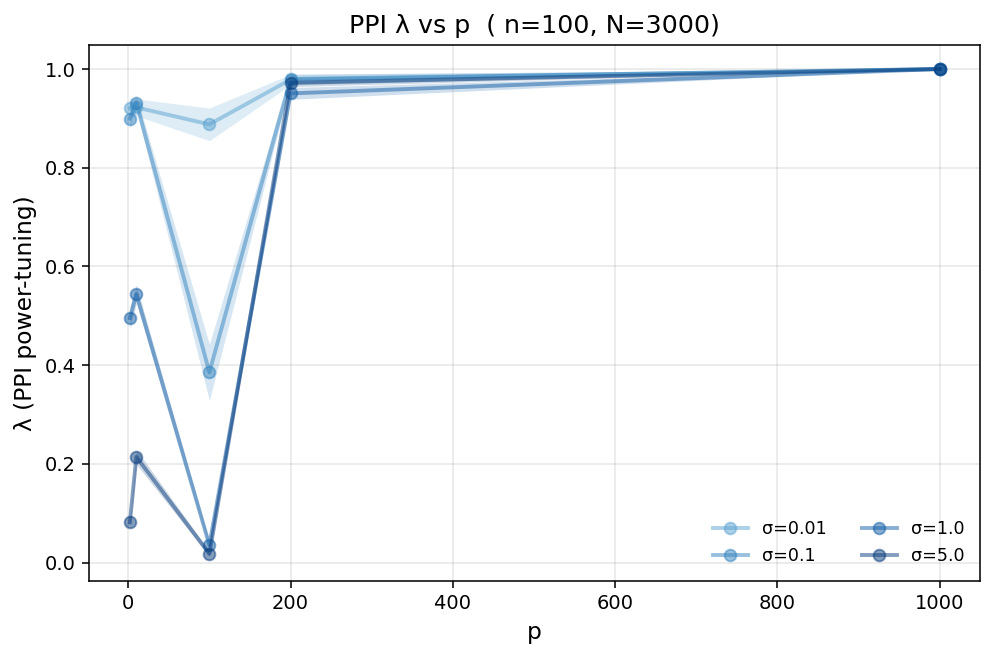

<Axes: title={'center': 'PPI λ vs p  ( n=100, N=3000)'}, xlabel='p', ylabel='λ (PPI power-tuning)'>

In [113]:
plot_ppi_lambda_vs_p(n=100, N_total=3000,savepath="../plots/ppi_lambda_vs_p_n100_N3000.png")